In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [190]:
evds=evdsAPI('dsIC3fiGlu')


In [191]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4593,11-09-2023,26.8570
4594,12-09-2023,26.8897
4595,13-09-2023,26.9066
4596,14-09-2023,26.9509


In [192]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [193]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


In [194]:
inflation=enf
inflation=pd.DataFrame(inflation)
inflation.columns=["Tarih","TÜFE"]


In [195]:

inflationagt=pd.DataFrame.from_dict({'Tarih':"2023-9",'TÜFE': [1717]})
inflation=pd.concat([inflation,inflationagt],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


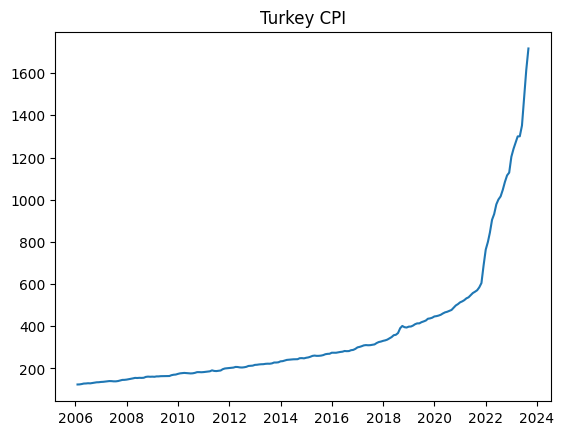

In [196]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [197]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [198]:
dates= pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6

,USD/TL,Onceki USD/TL
2006-02-01,1.326535,1.320000
2006-03-01,1.335139,1.326535
2006-04-01,1.337345,1.335139
2006-05-01,1.420659,1.337345
2006-06-01,1.600536,1.420659
...,...,...
2023-05-01,19.719514,19.337032
2023-06-01,23.106042,19.719514
2023-07-01,26.470338,23.106042
2023-08-01,26.999127,26.470338


In [199]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [200]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [201]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn["Para Arzi Onceki"]=dfn["Para Arzi"].shift(1)
dfn.iloc[0,1]=2.39
dfn


,Para Arzi,Para Arzi Onceki
2006-02-01,2.423895,2.390000
2006-03-01,2.494857,2.423895
2006-04-01,2.521919,2.494857
2006-05-01,2.751947,2.521919
2006-06-01,2.791388,2.751947
...,...,...
2023-05-01,94.093167,95.059993
2023-06-01,108.345324,94.093167
2023-07-01,114.784753,108.345324
2023-08-01,120.253199,114.784753


In [202]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4585,30-08-2023,86.62
4586,31-08-2023,87.29
4587,01-09-2023,89.98
4588,04-09-2023,90.42


In [203]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle
brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [204]:

brent1=pd.DataFrame(brent)
brent1.columns=["Brent"]
brent1


,Brent
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [205]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3566834801.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-01,60.210000
2006-03-01,62.064783
2006-04-01,70.260000
2006-05-01,69.776957
2006-06-01,68.555909
...,...
2023-05-01,75.466000
2023-06-01,74.839091
2023-07-01,80.108095


In [206]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09


In [207]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055


In [208]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\2513009782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-05-01,88.043441
2023-06-01,95.646045
2023-07-01,98.468952


In [209]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.iloc[:59,1]=5
pfaiz.iloc[210,1]=25
pfaiz


,Tarih,TP_APIFON4
0,2006-2,5.00
1,2006-3,5.00
2,2006-4,5.00
3,2006-5,5.00
4,2006-6,5.00
...,...,...
207,2023-5,9.09
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,25.00


In [210]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3293406371.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Politika Faizi
TIME,
2006-02-01,5.00
2006-03-01,5.00
2006-04-01,5.00
2006-05-01,5.00
2006-06-01,5.00
...,...
2023-05-01,9.09
2023-06-01,12.84
2023-07-01,17.50


In [211]:
X=pd.concat([df6["Onceki USD/TL"],dfn["Para Arzi Onceki"],df14.Brent,df3.Kredi,pfaiz["Politika Faizi"]],axis=1)



In [212]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y


,CPI
2006-02-01,123.84
2006-03-01,124.18
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
...,...
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84
2023-08-01,1614.31


In [213]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [214]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9696.
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          5.15e-178
Time:                        11:57:34   Log-Likelihood:                -618.93
No. Observations:                 148   AIC:                             1250.
Df Residuals:                     142   BIC:                             1268.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               84.8939      5.414  

In [215]:
results.params

const               84.893944
Onceki USD/TL        4.337170
Para Arzi Onceki    11.019208
Brent                0.207737
Kredi                1.193524
Politika Faizi       0.638032
dtype: float64

In [216]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df14.astype(float),
                                order=(0,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [217]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [218]:
pred_ci['Predicted'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
pred_ci['Observed'] = df14["Brent"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Brent,upper Brent,Predicted,Observed,"Diff, %%"
2022-12-01,76.757637,106.835953,91.796795,80.996667,13.334040
2023-01-01,70.379074,100.457389,85.418232,82.515909,3.517288
2023-02-01,69.737176,99.815492,84.776334,82.585000,2.653429
2023-03-01,66.325022,96.403337,81.364179,78.434348,3.735394
2023-04-01,52.829884,82.908200,67.869042,84.739474,-19.908587
2023-05-01,78.176313,108.254629,93.215471,75.466000,23.519825
2023-06-01,69.580579,99.658895,84.619737,74.839091,13.068900
2023-07-01,57.197032,87.275347,72.236190,80.108095,-9.826604
2023-08-01,60.315710,90.394025,75.354868,86.147727,-12.528316
2023-09-01,66.090153,96.168469,81.129311,90.550000,-10.403853


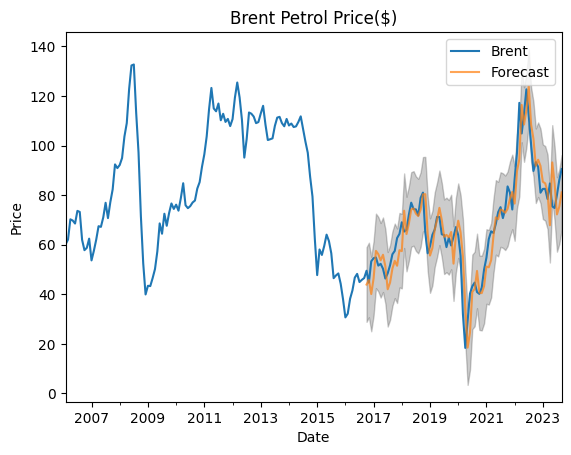

In [219]:
ax = df14['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [220]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

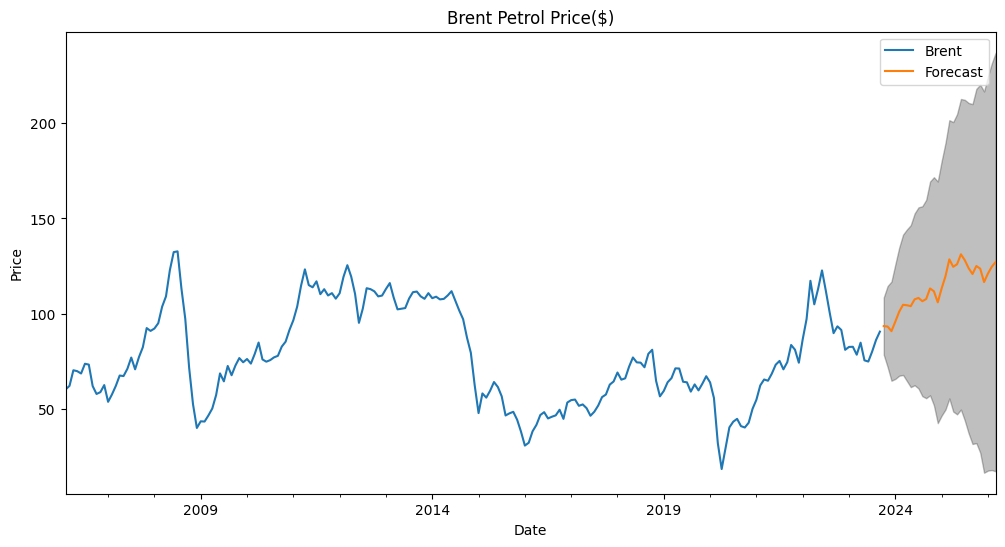

In [221]:
ax = df14.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [222]:
pred_ci['Mean'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
brenttahmin=pred_ci["Mean"]
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]
brenttahmin



,Brent
2023-10-01,93.446344
2023-11-01,93.232299
2023-12-01,90.802761
2024-01-01,95.791469
2024-02-01,101.002054
2024-03-01,104.643949
2024-04-01,104.400700
2024-05-01,103.931412
2024-06-01,107.503428
2024-07-01,108.254603


In [223]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(dfn["Para Arzi Onceki"].astype(float),
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [224]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [225]:
pred_ci['Predicted'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
pred_ci['Observed'] = dfn["Para Arzi Onceki"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Para Arzi Onceki,upper Para Arzi Onceki,Predicted,Observed,"Diff, %%"
2022-12-01,79.788146,83.861026,81.824586,79.312824,3.166906
2023-01-01,80.897839,84.970553,82.934196,82.127970,0.981670
2023-02-01,83.538939,87.611491,85.575215,84.330974,1.475426
2023-03-01,85.913395,89.985947,87.949671,86.852197,1.263612
2023-04-01,89.279521,93.351911,91.315716,90.592762,0.798027
2023-05-01,92.887964,96.960194,94.924079,95.059993,-0.142976
2023-06-01,97.777117,101.849190,99.813153,94.093167,6.079067
2023-07-01,96.512535,100.584454,98.548495,108.345324,-9.042226
2023-08-01,111.514846,115.586613,113.550730,114.784753,-1.075076
2023-09-01,118.297273,122.368892,120.333082,120.253199,0.066429


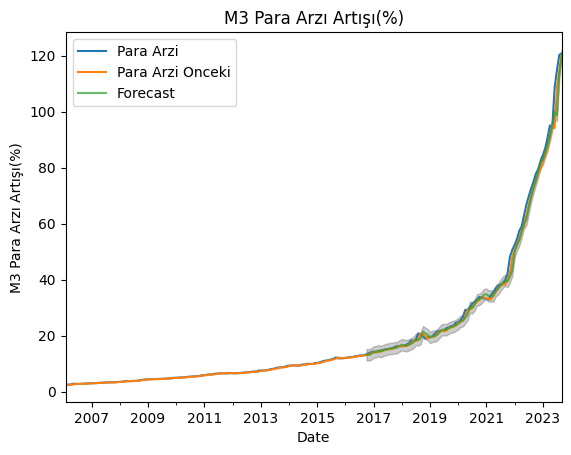

In [226]:
ax = dfn['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('M3 Para Arzı Artışı(%)')
plt.title("M3 Para Arzı Artışı(%)")
plt.legend()
plt.show()

In [227]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

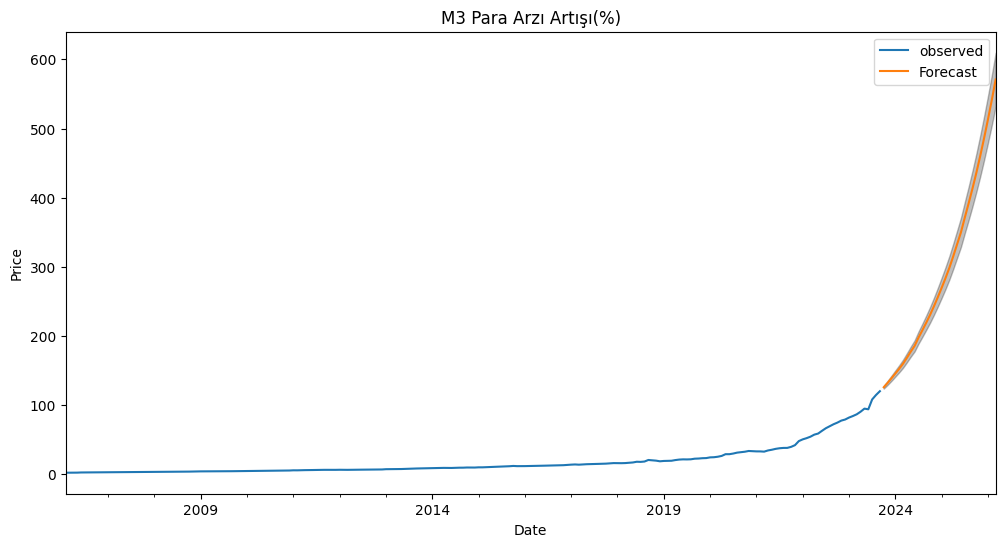

In [228]:
ax = dfn["Para Arzi Onceki"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("M3 Para Arzı Artışı(%)")

plt.legend()

plt.show()

In [229]:
import random
import numpy as np
pred_ci['Mean'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
paraarzitahmin=pred_ci["Mean"]
paraarzitahmin=pd.DataFrame(paraarzitahmin)
paraarzitahmin.columns=["Para Arzi Tahmin"]
paraarzitahmin




,Para Arzi Tahmin
2023-10-01,125.963854
2023-11-01,132.260751
2023-12-01,138.929116
2024-01-01,145.810407
2024-02-01,152.670197
2024-03-01,160.011938
2024-04-01,168.564053
2024-05-01,177.445761
2024-06-01,185.802916
2024-07-01,197.631716


In [230]:
y=float(input('Para Arzi Aylık En Fazla % Kaç Artacağını Girin: '))
def paraarziassumption(y):
   drop_percentage = random.uniform(1+(y/300), 1+(y/100))
   
   paraarzitahmin["Para Arzi Assumption 2"]=paraarzitahmin["Para Arzi Tahmin"]
   
   for i in range(0, len(paraarzitahmin)-1):
   
      paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
   return paraarzitahmin
      
paraarziassumption(y)


C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\1571707984.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\1571707984.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\1571707984.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,Para Arzi Tahmin,Para Arzi Assumption 2
2023-10-01,125.963854,125.963854
2023-11-01,132.260751,129.335410
2023-12-01,138.929116,132.797211
2024-01-01,145.810407,136.351670
2024-02-01,152.670197,140.001268
2024-03-01,160.011938,143.748551
2024-04-01,168.564053,147.596134
2024-05-01,177.445761,151.546702
2024-06-01,185.802916,155.603011
2024-07-01,197.631716,159.767892


In [231]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df6["USD/TL"].astype(float),
                                order=(0,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [232]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [233]:
pred_ci['Predicted'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
pred_ci['Observed'] = df6["USD/TL"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower USD/TL,upper USD/TL,Predicted,Observed,"Diff, %%"
2022-12-01,18.099736,19.611575,18.855656,18.670545,0.991456
2023-01-01,17.571437,19.083276,18.327357,18.791373,-2.469303
2023-02-01,18.162000,19.673839,18.917919,18.857210,0.321942
2023-03-01,18.675981,20.187820,19.431901,19.003478,2.254442
2023-04-01,18.389138,19.900977,19.145058,19.337032,-0.992779
2023-05-01,19.064389,20.576228,19.820309,19.719514,0.511141
2023-06-01,19.355849,20.867688,20.111768,23.106042,-12.958834
2023-07-01,24.482947,25.994786,25.238866,26.470338,-4.652271
2023-08-01,26.623874,28.135713,27.379793,26.999127,1.409919
2023-09-01,26.097769,27.609607,26.853688,26.842091,0.043205


In [234]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

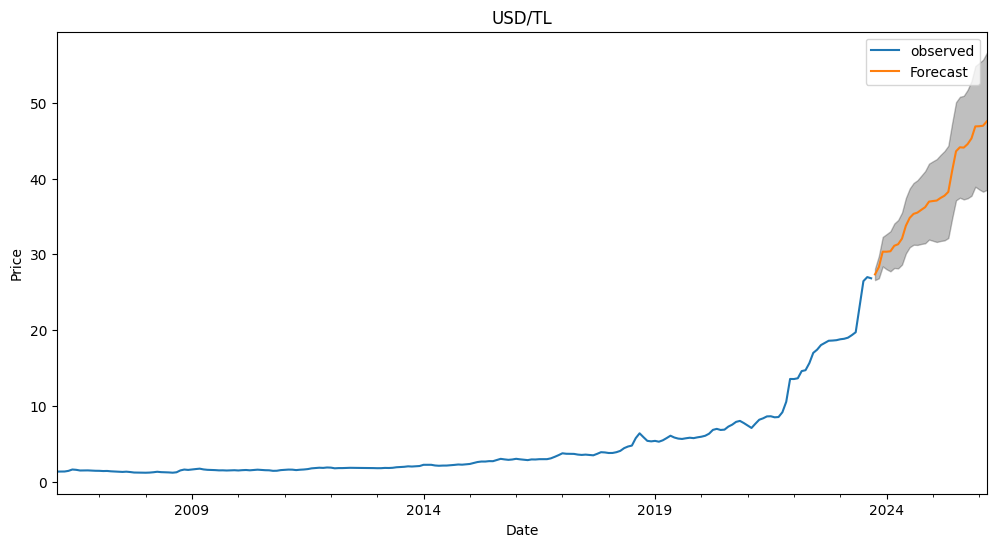

In [235]:
ax = df6["USD/TL"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL")

plt.legend()

plt.show()

In [236]:
pred_ci['Mean'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
usdtahmin=pred_ci["Mean"]
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD Tahmin"]







usdtahmin

,USD Tahmin
2023-10-01,27.357086
2023-11-01,28.316813
2023-12-01,30.355789
2024-01-01,30.350189
2024-02-01,30.408820
2024-03-01,31.135507
2024-04-01,31.340142
2024-05-01,32.085007
2024-06-01,33.778097
2024-07-01,34.821734


In [237]:
import random
x=float(input('Dolar/TL Aylık En Fazla % Kaç Artacağını Girin:   '))
def usdassumption(x):
    
  drop_percentage = random.uniform(1+(x/200), 1+(x/100))
  usdtahmin["USD Tahmin Assumption 2"]=usdtahmin["USD Tahmin"]
  for i in range(0, len(usdtahmin)-3):
   
    usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage

  return usdtahmin

usdassumption(x)
  



C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\4181643103.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\4181643103.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\4181643103.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

,USD Tahmin,USD Tahmin Assumption 2
2023-10-01,27.357086,27.357086
2023-11-01,28.316813,28.316813
2023-12-01,30.355789,30.355789
2024-01-01,30.350189,31.069250
2024-02-01,30.408820,31.799480
2024-03-01,31.135507,32.546873
2024-04-01,31.340142,33.311832
2024-05-01,32.085007,34.094770
2024-06-01,33.778097,34.896109
2024-07-01,34.821734,35.716283


In [238]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [239]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [240]:
pred_ci['Predicted'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
pred_ci['Observed'] = df3["Kredi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Kredi,upper Kredi,Predicted,Observed,"Diff, %%"
2022-12-01,69.467707,72.365714,70.916711,72.851339,-2.655584
2023-01-01,72.580977,75.478983,74.029980,75.079809,-1.398285
2023-02-01,75.577323,78.475329,77.026326,77.112692,-0.112000
2023-03-01,78.682452,81.580458,80.131455,82.109915,-2.409527
2023-04-01,83.730472,86.628478,85.179475,85.721139,-0.631890
2023-05-01,87.379865,90.277871,88.828868,88.043441,0.892090
2023-06-01,89.472799,92.370805,90.921802,95.646045,-4.939297
2023-07-01,97.428110,100.326116,98.877113,98.468952,0.414507
2023-08-01,98.860137,101.758143,100.309140,99.238055,1.079309
2023-09-01,101.349481,104.247487,102.798484,100.328877,2.461512


In [241]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

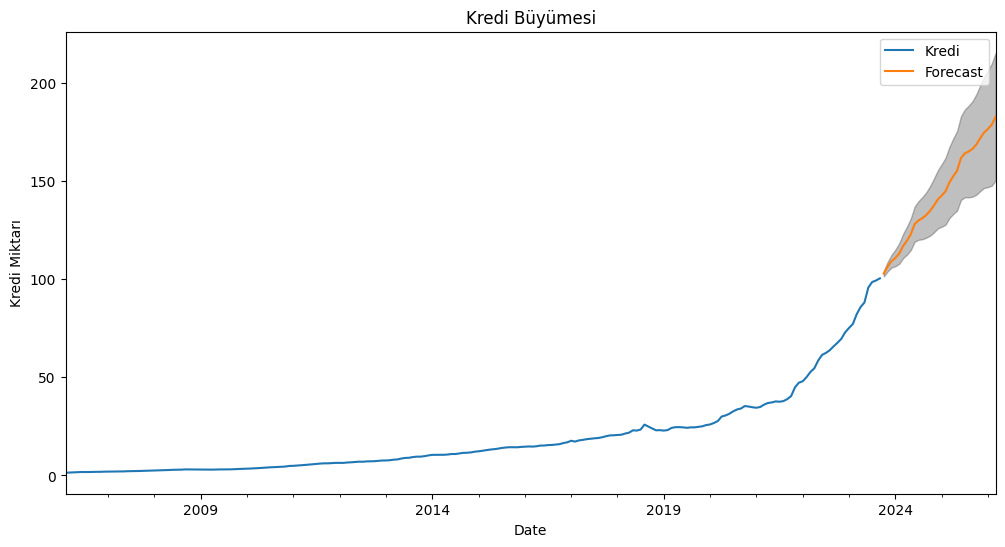

In [242]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Kredi Miktarı')
plt.title("Kredi Büyümesi")

plt.legend()

plt.show()

In [243]:
import random
pred_ci['Mean'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
kreditahmin=pred_ci["Mean"]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi Tahmin"]
kreditahmin




,Kredi Tahmin
2023-10-01,102.722800
2023-11-01,106.270261
2023-12-01,109.036104
2024-01-01,110.703522
2024-02-01,112.939907
2024-03-01,116.716541
2024-04-01,119.476552
2024-05-01,122.744841
2024-06-01,127.889501
2024-07-01,129.800032


In [244]:
z=float(input('Kredi Hacmi Aylık En Fazla % Kaç Artacağını Girin: '))
def krediassumption(z):

   drop_percentage = random.uniform(0.97, 1+(z/100))
   drop_percentage1=random.uniform(0.005, 0.01)
   kreditahmin["Kredi Tahmin Assumption 2"]=kreditahmin["Kredi Tahmin"]
   for i in range(0, len(kreditahmin)-1):
   
      kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
   return kreditahmin
krediassumption(z)
   

C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3476548468.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3476548468.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3476548468.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,Kredi Tahmin,Kredi Tahmin Assumption 2
2023-10-01,102.722800,102.722800
2023-11-01,106.270261,101.347545
2023-12-01,109.036104,99.990702
2024-01-01,110.703522,98.652024
2024-02-01,112.939907,97.331268
2024-03-01,116.716541,96.028195
2024-04-01,119.476552,94.742567
2024-05-01,122.744841,93.474152
2024-06-01,127.889501,92.222718
2024-07-01,129.800032,90.988038


In [245]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(pfaiz.astype(float),
                                order=(3,1,0),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [246]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [247]:
pred_ci['Predicted'] = (pred_ci["lower Politika Faizi"] + pred_ci["upper Politika Faizi"])/2
pred_ci['Observed'] = pfaiz["Politika Faizi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Politika Faizi,upper Politika Faizi,Predicted,Observed,"Diff, %%"
2022-12-01,6.013569,10.226072,8.119821,9.04,-10.178974
2023-01-01,6.772671,10.985174,8.878923,9.00,-1.345301
2023-02-01,6.470151,10.682654,8.576402,8.76,-2.095866
2023-03-01,6.841642,11.054143,8.947892,8.56,4.531450
2023-04-01,5.746129,9.958624,7.852377,8.70,-9.742797
2023-05-01,7.102058,11.314552,9.208305,9.09,1.301483
2023-06-01,6.996135,11.208628,9.102382,12.84,-29.109176
2023-07-01,11.232390,15.444883,13.338637,17.50,-23.779220
2023-08-01,18.673182,22.885675,20.779428,25.00,-16.882287
2023-09-01,26.471280,30.683774,28.577527,25.87,10.465894


In [248]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

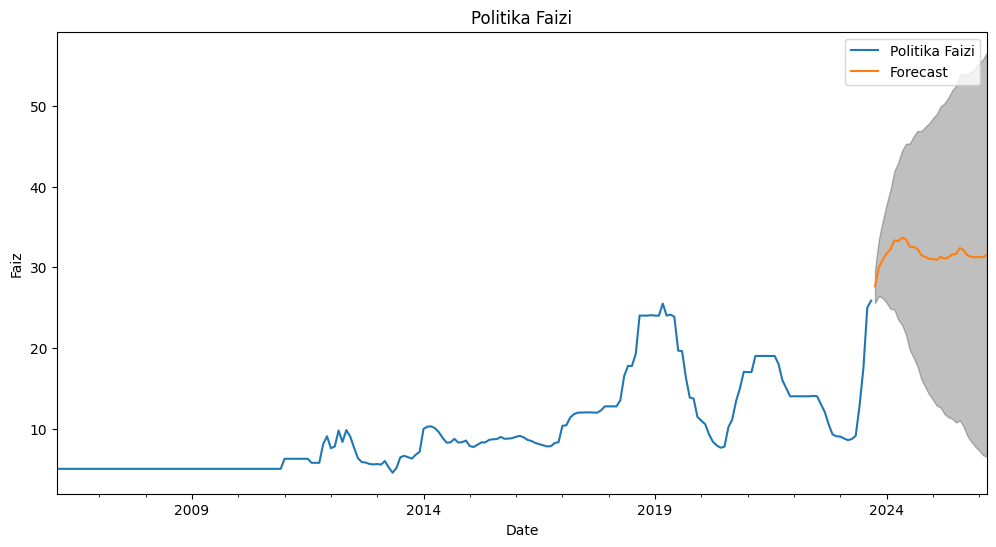

In [249]:
ax = pfaiz.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Faiz')
plt.title("Politika Faizi")

plt.legend()

plt.show()

In [250]:
pred_ci['Mean'] = (pred_ci["lower Politika Faizi"] + pred_ci["upper Politika Faizi"])/2
faiztahmin=pred_ci["Mean"]
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
faiztahmin["Politika Faizi"]=faiztahmin["Politika Faizi"].astype(int)
faiztahmin

,Politika Faizi
2023-10-01,27
2023-11-01,29
2023-12-01,30
2024-01-01,31
2024-02-01,32
2024-03-01,33
2024-04-01,33
2024-05-01,33
2024-06-01,33
2024-07-01,32


In [251]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()










res2=[]
res3=[]


for i in range(30):
    res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
    res3.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
   
    



df9=pd.DataFrame()
dates=pd.date_range('2023-09-01','2026-03-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["Inflation"]=res2
df9["Assumption 2 Inflation"]=res3
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
df9

C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\655677746.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\655677746.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res3.append(results.params["const"]+results.params["Onceki USD/TL

,Inflation,Assumption 2 Inflation
2023-09-01,1750.809411,1750.809411
2023-10-01,1829.824308,1791.713997
2023-11-01,1915.582225,1837.217584
2023-12-01,1995.048790,1879.555934
2024-01-01,2075.282177,1923.082852
2024-02-01,2165.236211,1967.455852
2024-03-01,2263.604885,2011.585971
2024-04-01,2368.508178,2056.902464
2024-05-01,2474.822943,2104.323746
2024-06-01,2611.491662,2151.819058


In [252]:

data=pd.DataFrame()
dates=pd.date_range(start='2006-02-01', periods=212, freq='M')

# Veriyi bir veri çerçevesine yerleştirme


data["Döviz Kuru"]=df6["Onceki USD/TL"]
data["Para Arzı"]=dfn["Para Arzi"]
data["Petrol"]=df14["Brent"]
data["Kredi Hacmi"]=df3["Kredi"]
data["TÜFE"]=df["CPI"]
data.set_index(dates, inplace=True)
data.dropna(inplace=True)
data=data.head(211)
data





,Döviz Kuru,Para Arzı,Petrol,Kredi Hacmi,TÜFE
2006-02-28,1.320000,2.423895,60.210000,1.381847,123.84
2006-03-31,1.326535,2.494857,62.064783,1.481222,124.18
2006-04-30,1.335139,2.521919,70.260000,1.527510,125.84
2006-05-31,1.337345,2.751947,69.776957,1.664881,128.20
2006-06-30,1.420659,2.791388,68.555909,1.740395,128.63
...,...,...,...,...,...
2023-04-30,19.003478,95.059993,84.739474,85.721139,1300.04
2023-05-31,19.337032,94.093167,75.466000,88.043441,1300.60
2023-06-30,19.719514,108.345324,74.839091,95.646045,1351.59
2023-07-31,23.106042,114.784753,80.108095,98.468952,1479.84


In [253]:
import numpy as np
import pandas as pd
import statsmodels.api as sm




# VAR modelini oluşturun
model = sm.tsa.VAR(data)

# Modeli uyarlayın
results = model.fit(maxlags=4)  # İhtiyaca göre maksimum gecikme düzeyini ayarlayabilirsiniz



# Tahminler yapın (örneğin, 12 aylık öngörü)
forecast_horizon = 12
forecast = results.forecast(y=results.endog, steps=forecast_horizon)

forecast=pd.DataFrame(forecast[:,4])
forecast.columns=["TÜFE"]
forecast


,TÜFE
0,1719.842940
1,1839.638658
2,1917.729998
3,1959.437987
4,2019.145913
5,2106.923693
6,2208.486516
7,2351.335828
8,2503.442715
9,2644.485399


In [254]:
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin5=pd.DataFrame(forecast["TÜFE"])
tahmin5=tahmin5.set_index(dates)
tahmin5.columns=["TÜFE"]
tahmin5

,TÜFE
2023-09-01,1719.842940
2023-10-01,1839.638658
2023-11-01,1917.729998
2023-12-01,1959.437987
2024-01-01,2019.145913
2024-02-01,2106.923693
2024-03-01,2208.486516
2024-04-01,2351.335828
2024-05-01,2503.442715
2024-06-01,2644.485399


In [255]:
data["random_walk_component"] = data['Döviz Kuru'].shift(1)
data=data.dropna()
data

,Döviz Kuru,Para Arzı,Petrol,Kredi Hacmi,TÜFE,random_walk_component
2006-03-31,1.326535,2.494857,62.064783,1.481222,124.18,1.320000
2006-04-30,1.335139,2.521919,70.260000,1.527510,125.84,1.326535
2006-05-31,1.337345,2.751947,69.776957,1.664881,128.20,1.335139
2006-06-30,1.420659,2.791388,68.555909,1.740395,128.63,1.337345
2006-07-31,1.600536,2.711670,73.674286,1.731811,129.72,1.420659
...,...,...,...,...,...,...
2023-04-30,19.003478,95.059993,84.739474,85.721139,1300.04,18.857210
2023-05-31,19.337032,94.093167,75.466000,88.043441,1300.60,19.003478
2023-06-30,19.719514,108.345324,74.839091,95.646045,1351.59,19.337032
2023-07-31,23.106042,114.784753,80.108095,98.468952,1479.84,19.719514


In [256]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa



# Parametrelerin zaman içinde değişeceği random walk süreçlerini oluşturun
param_dolar = np.cumsum(np.random.randn(210))  # Dolar parametresi için


# Hata teriminin zaman içinde değişeceği süreci oluşturun (2 lag)
error_term = np.random.randn(210)
for t in range(2, 210):
    error_term[t] += 0.7 * error_term[t - 1] + 0.2 * error_term[t - 2]

# Hata teriminin dağılımı için t-dağılımı kullanın (serbestlik derecesi tahmin ediliyor)
degrees_of_freedom = np.abs(np.random.randn(210)) * 10 + 2  # Rastgele serbestlik derecesi

# Stokastik volatiliteyi oluşturun (varyans da zaman içinde random walk)
volatility = np.exp(np.cumsum(np.random.randn(210)))  # Logaritmik volatiliteyi oluşturun

# Tüm bu oluşturulan süreçleri bir DataFrame'e ekleyin
data['Param_Dolar'] = param_dolar
data['Error_Term'] = error_term
data['Degrees_of_Freedom'] = degrees_of_freedom
data['Volatility'] = volatility

model_data = data
model = tsa.VAR(model_data)

# Modeli uyarlayın (4 lag)
results = model.fit(maxlags=1)

# Tahminleri yapın (örneğin, son 12 aylık öngörü)
forecast_horizon = 12
forecast_input = model_data.iloc[-4:, :].values  # Son 4 gözlemi kullanarak tahmin ediyoruz
forecast = results.forecast(y=forecast_input, steps=forecast_horizon)

forecast=pd.DataFrame(forecast[:,4])
forecast.columns=["TÜFE"]
forecast



C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3013777412.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Param_Dolar'] = param_dolar
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3013777412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Error_Term'] = error_term
C:\Users\Bora\AppData\Local\Temp\ipykernel_8432\3013777412.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,TÜFE
0,1712.750132
1,1794.426156
2,1866.670228
3,1937.760156
4,2014.016982
5,2099.021049
6,2193.944074
7,2298.412936
8,2411.416057
9,2531.979369


In [257]:
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin6=pd.DataFrame(forecast["TÜFE"])
tahmin6=tahmin6.set_index(dates)
tahmin6.columns=["TÜFE"]
tahmin6

,TÜFE
2023-09-01,1712.750132
2023-10-01,1794.426156
2023-11-01,1866.670228
2023-12-01,1937.760156
2024-01-01,2014.016982
2024-02-01,2099.021049
2024-03-01,2193.944074
2024-04-01,2298.412936
2024-05-01,2411.416057
2024-06-01,2531.979369


In [258]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm


model = sm.VECM(data)
results = model.fit()

# TÜFE'nin gelecekteki değerlerini tahmin et
tahmin = results.predict(steps=12, alpha=0.05)

tahmin1=pd.DataFrame(tahmin[0],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE','random_walk_component','Param_Dolar','Error_Term','Degrees_of_Freedom','Volatility'])


tahmin2=pd.DataFrame(tahmin[1],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE','random_walk_component','Param_Dolar','Error_Term','Degrees_of_Freedom','Volatility'])
tahmin3=pd.DataFrame(tahmin[2],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE','random_walk_component','Param_Dolar','Error_Term','Degrees_of_Freedom','Volatility'])

tahmin4=pd.DataFrame()
tahmin4["TÜFE"]=(tahmin1["TÜFE"]+tahmin1["random_walk_component"]+tahmin2["TÜFE"]+tahmin2["random_walk_component"]+tahmin3["TÜFE"]+tahmin3["random_walk_component"])/3
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin4=tahmin4.set_index(dates)
tahmin4

,TÜFE
2023-09-01,1735.200952
2023-10-01,1796.648778
2023-11-01,1850.545121
2023-12-01,1912.176687
2024-01-01,1988.670574
2024-02-01,2076.555042
2024-03-01,2169.468982
2024-04-01,2263.517086
2024-05-01,2358.270095
2024-06-01,2455.167133


In [259]:
dff=pd.concat([df["CPI"].head(211),df9["Inflation"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas2=pd.concat([df["CPI"].head(211),df9["Assumption 2 Inflation"]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["CPI"]





dfas4=pd.concat([df["CPI"].head(211),tahmin4["TÜFE"]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=["CPI"]

dfas5=pd.concat([df["CPI"].head(211),tahmin5["TÜFE"]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=["CPI"]




dfas6=pd.concat([df["CPI"].head(211),tahmin6["TÜFE"]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=["CPI"]
dfas6







,CPI
2006-02-01,123.840000
2006-03-01,124.180000
2006-04-01,125.840000
2006-05-01,128.200000
2006-06-01,128.630000
...,...
2024-04-01,2298.412936
2024-05-01,2411.416057
2024-06-01,2531.979369
2024-07-01,2659.528942


In [260]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas2['onceki_yil_tufe'] = dfas2['CPI'].shift(12)
dfas4['onceki_yil_tufe'] = dfas4['CPI'].shift(12)
dfas5['onceki_yil_tufe'] = dfas5['CPI'].shift(12)
dfas6['onceki_yil_tufe'] = dfas6['CPI'].shift(12)


# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas2['yillik_enflasyon_orani'] = ((dfas2['CPI'] / dfas2['onceki_yil_tufe']) - 1) * 100
dfas4['yillik_enflasyon_orani'] = ((dfas4['CPI'] / dfas4['onceki_yil_tufe']) - 1) * 100
dfas5['yillik_enflasyon_orani'] = ((dfas5['CPI'] / dfas5['onceki_yil_tufe']) - 1) * 100
dfas6['yillik_enflasyon_orani'] = ((dfas6['CPI'] / dfas6['onceki_yil_tufe']) - 1) * 100
# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas2.dropna(inplace=True)
dfas4.dropna(inplace=True)
dfas5.dropna(inplace=True)
dfas6.dropna(inplace=True)




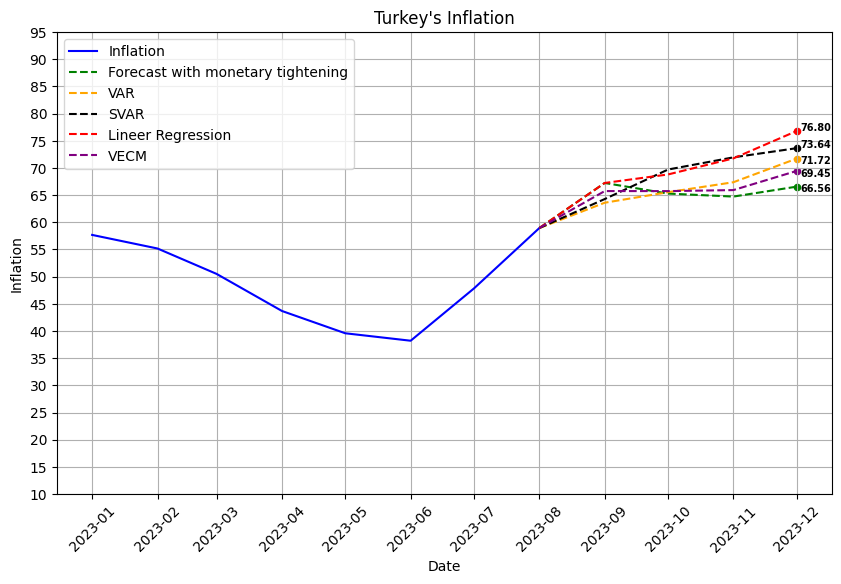

In [264]:
dates=pd.date_range('2008-02-01','2026-02-01' , freq='1M')-pd.offsets.MonthBegin(1)






# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[191:199]["yillik_enflasyon_orani"], label='Inflation', color='blue')
plt.plot(dfas2.iloc[198:203]["yillik_enflasyon_orani"],'--', label='Forecast with monetary tightening', color='green')
plt.plot(dfas6.iloc[198:203]["yillik_enflasyon_orani"],'--',label='VAR', color='orange'    )
plt.plot(dfas5.iloc[198:203]["yillik_enflasyon_orani"],'--',label='SVAR', color='black')
plt.plot(dff.iloc[198:203]["yillik_enflasyon_orani"],'--',label='Lineer Regression', color='red')
plt.plot(dfas4.iloc[198:203]["yillik_enflasyon_orani"],'--',label='VECM', color='purple')



plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dff.iloc[191:212].index, dff.iloc[191:212].index.strftime('%Y-%m'), rotation=45)
y_max = int(max(dff["yillik_enflasyon_orani"].iloc[191:212]))
y_min = 10
y_interval = 0.5
y_ticks = [y_min]
while y_ticks[-1] < y_max:
    y_ticks.append(y_ticks[-1] + 5)

son_dort_veri=dff["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri3=dfas4["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri4=dfas5["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri5=dfas6["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri6=dfas2["yillik_enflasyon_orani"].iloc[202:203]

# Y ekseni etiketlerini ayarlama
for i, v in enumerate(son_dort_veri):
    plt.annotate(f'{v:.2f}', (son_dort_veri.index[i], v), xytext=(3, 0), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri.index,son_dort_veri,color='red',s=20)


for i, v in enumerate(son_dort_veri3):
    plt.annotate(f'{v:.2f}', (son_dort_veri3.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri3.index,son_dort_veri3,color='purple',s=20)

for i,v in enumerate(son_dort_veri4):
    plt.annotate(f'{v:.2f}', (son_dort_veri4.index[i], v), xytext=(3, 0), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri4.index,son_dort_veri4,color='black',s=20)


for i,v in enumerate(son_dort_veri5):
    plt.annotate(f'{v:.2f}', (son_dort_veri5.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri5.index,son_dort_veri5,color='orange',s=20)

for i,v in enumerate(son_dort_veri6):
    plt.annotate(f'{v:.2f}', (son_dort_veri5.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri6.index,son_dort_veri6,color='green',s=20)






# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()
